In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
from candle import Module, Tensor
import candle.functions as F

## Sparse Attention Implementation

The key idea for an efficient implementation is, if we slice out the sequence into blocks, then `fixed` sparse attention only requires attending to elements in the **same block**, while `strided` only requires attending to the **same block** and **previous block**.

(note: I'm not sure if this is how the official repo does it, this is just my personal implementation)

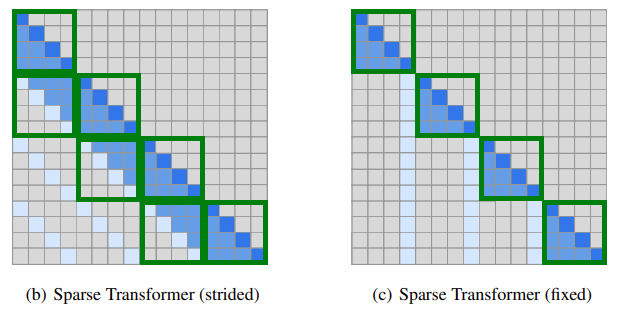
<br /><sup>(Figure modified from [Generating Long Sequences with Sparse Transformers, Rewon Child & Scott Gray & Alec Radford & Ilya Sutskever 2019](](https://arxiv.org/pdf/1904.10509.pdf)))</sup>

## (0) Contents

* [(1) Fixed Sparse Attention](#(1)-Fixed-Sparse-Attention)
* [(2) Strided Sparse Attention](#(2)-Strided-Sparse-Attention)
* [(3) Visualize Attention Implementations](#(3)-Visualize-Attention-Implementations)

## (1) Fixed Sparse Attention

In [3]:
class FixedSparseAttention(Module):
    """Fixed sparse autoregressive attention."""
    
    def __init__(self,
                 block_size: int):
        super().__init__()
        self.block_size = block_size
        
        
    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor):
        """Does attention aggregation.
        
        Args:
            query, key, value (Tensor): shape (batch, seqlen, embed_dim)
                seqlen must be divisible by block_size.
            
        Returns:
            Tensor: attn_output with shape (batch, seqlen, embed_dim)
            
        """
        (batch, seqlen, embed_dim) = query.shape
        n_blocks = seqlen // self.block_size

        # shape (batch, n_blocks, block_size, embed_dim)
        query = reshape_into_subblocks(query, self.block_size)
        key = reshape_into_subblocks(key, self.block_size)
        value = reshape_into_subblocks(value, self.block_size)

        # Attend to current subblock

        # shape (batch, n_blocks, block_size, block_size)
        logits = F.bmm(query, key.transpose(-1, -2)) / np.sqrt(embed_dim)
        
        causal_attn_mask = Tensor(1 - np.tri(self.block_size))
        logits = F.masked_fill(logits, causal_attn_mask, fill_value=-1e9)

        # Aggregate by subblock
        
        attn_scores = F.softmax(logits)
        attn_output = F.bmm(attn_scores, value)
        
        attn_output = attn_output.reshape((batch, seqlen, embed_dim))
        
        return attn_output
        
        
    def __repr__(self):
        return f'FixedSparseAttention(dropout={self.block_size})'


def reshape_into_subblocks(x: Tensor, block_size: int):
    """Transposes a Tensor x into sub-blocks.

    Args:
        x: shape (batch, seqlen, embed_dim)
        block_size: size of sub-blocks.

    Returns
        Tensor: shape (batch, seqlen // subblocks, subblocks, embed_dim)
    
    """
    (batch, seqlen, embed_dim) = x.shape
    
    if seqlen % block_size != 0:
        raise ValueError(f'seqlen dimension = {seqlen} must be divisible by block_size = {block_size}.')

    x = x.reshape((batch, seqlen // block_size, block_size, embed_dim))

    return x

## (2) Strided Sparse Attention

In [4]:
class StridedSparseAttention(Module):
    """Strided sparse autoregressive attention."""
    
    def __init__(self,
                 block_size: int):
        super().__init__()
        self.block_size = block_size
        
        
    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor):
        """Does attention aggregation.
        
        Args:
            query, key, value (Tensor): shape (batch, seqlen, embed_dim)
                seqlen must be divisible by block_size.
            
        Returns:
            Tensor: attn_output with shape (batch, seqlen, embed_dim)
            
        """
        NEG_INF = -1e9
        (batch, seqlen, embed_dim) = query.shape
        n_blocks = seqlen // self.block_size

        # shape (batch, n_blocks, block_size, embed_dim)
        query = reshape_into_subblocks(query, self.block_size)
        key = reshape_into_subblocks(key, self.block_size)
        value = reshape_into_subblocks(value, self.block_size)
        
        query_prev = query[:, 1:]
        key_prev = key[:, :-1]
        value_prev = value[:, :-1]
        
        # Attend to current subblock

        # shape (batch, n_blocks, block_size, block_size)
        logits = F.bmm(query, key.transpose(-1, -2)) / np.sqrt(embed_dim)
        
        causal_attn_mask = Tensor(1 - np.tri(self.block_size))
        logits = F.masked_fill(logits, causal_attn_mask, fill_value=-1e9)
        
        # Attend to previous subblock

        # shape (batch, n_blocks - 1, block_size, block_size)
        logits_prev = F.bmm(query_prev, key_prev.transpose(-1, -2)) / np.sqrt(embed_dim)
        
        prev_attn_mask = Tensor(np.tri(self.block_size))
        logits_prev = F.masked_fill(logits_prev, prev_attn_mask, fill_value=NEG_INF)

        # pad to shape (batch, n_blocks, block_size, block_size)
        neg_inf = Tensor(NEG_INF * np.ones((batch, 1, self.block_size, self.block_size)))
        logits_prev = F.concat([neg_inf, logits_prev], axis=1)
        
        # Aggregate attention between previous and current subblocks

        # shape (batch, n_blocks, block_size, 2 * block_size)
        logits_prev_and_curr = F.concat([logits_prev, logits], axis=-1)
        attn_scores = F.softmax(logits_prev_and_curr)
        
        (attn_scores_prev, attn_scores) = attn_scores.split([self.block_size, self.block_size],
                                                            axis=-1)
        
        attn_output = F.bmm(attn_scores, value)
        attn_output_prev = F.bmm(attn_scores_prev[:, 1:], value_prev)
        
        attn_output[:, 1:] += attn_output_prev
        attn_output = attn_output.reshape((batch, seqlen, embed_dim))

        return attn_output
        
        
    def __repr__(self):
        return f'StridedSparseAttention(dropout={self.block_size})'

## (3) Visualize Attention Implementations
We test our implementations via visualization.

In [3]:
def visualize_attention(attn_layer: Module, seqlen: int):
    """Visualize attention scores."""
    embed_dim = 32
    
    query = candle.rand(1, seqlen, embed_dim)
    key = candle.rand(1, seqlen, embed_dim)
    value = candle.rand(1, seqlen, embed_dim)
    
    attn_output = attn_layer.forward(query, key, value)
    
    # Perturb the value, and see which elements in the output respond
    
    attn_scores = []
    for i in range(seqlen):
        value_perturbed = value.clone()
        value_perturbed[:, i, :] += 10 * candle.rand(1, embed_dim)
        
        perturbed_attn_output = attn_layer.forward(query, key, value_perturbed)
        
        delta = attn_output - perturbed_attn_output
        delta_at_indices = np.abs(delta.data).sum(axis=(0, 2))
        
        attn_scores.append(delta_at_indices > 1e-9)
    
    attn_scores = np.stack(attn_scores).T
    
    # Visualize attention
    
    plt.imshow(attn_scores)
    plt.xticks(range(seqlen))
    plt.show()

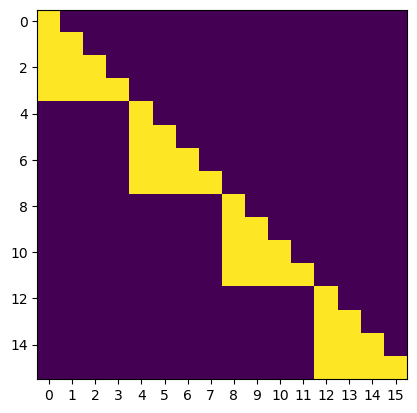

In [6]:
# Fixed Sparse Attention

visualize_attention(attn_layer=FixedSparseAttention(block_size=4),
                    seqlen=16)

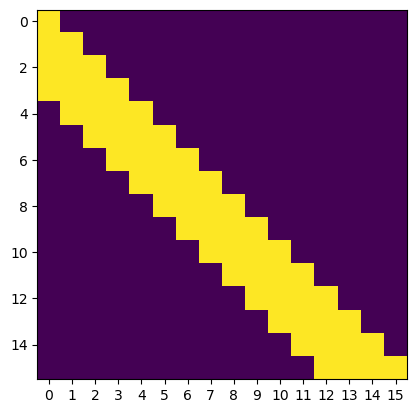

In [7]:
# Strided Sparse Attention

visualize_attention(attn_layer=StridedSparseAttention(block_size=4),
                    seqlen=16)